In [1]:

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"kesav994","key":"9f086835495a1adc15c98c17b26c0012"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:27<00:00, 216MB/s]
100% 6.31G/6.31G [00:27<00:00, 243MB/s]


# New Section

In [2]:

!unzip "../content/histopathologic-cancer-detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

## Step one:
## Brief description
The problem given is binary classification of the presence of metastic tissue in small image patches taken from larger digital pathology scans. The train category consists of 250k image files in tif format and a csv files containing labels and id for each train image. The test data consists of 55.5k image files in tif format.

In [3]:
!pip install gdal
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

from osgeo import gdal
import matplotlib.pyplot as plt

TRAIN_DIR = '/content/train/'
TEST_DIR = '../content/test/'

# get the list of jpegs from sub image class folders
trainImgIds = [fn for fn in os.listdir(TRAIN_DIR) if fn.endswith('.tif')]
print("Number of train images = " , len(trainImgIds))

testImgIds = [fn for fn in os.listdir(TEST_DIR) if fn.endswith('.tif')]
print("Number of train images = " , len(testImgIds))

trainLabelsDF = pd.read_csv('../content/train_labels.csv')
print("info on train labels")
print(trainLabelsDF.info())
print("5 rows of train labels dataframe")
print(trainLabelsDF.head())

trainLabelsDF['label'] = trainLabelsDF['label'].astype('|S') # convering object data type to string



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Number of train images =  220025
Number of train images =  57458
info on train labels
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
5 rows of train labels dataframe
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## Step two
Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 
Data is loaded. A few samples of data are visualized and unusable data are removed to improve performance

In [4]:
# REORDER TRAIN LABEL ID ACCORDING TO TRAIN IMG IDS
trainImgIdsNames = [x.replace(".tif",'') for  x in trainImgIds]
print(trainImgIdsNames[:5])
trainLabelsDFmodified = trainLabelsDF.set_index('id')
print(trainLabelsDFmodified.info())
print(trainLabelsDFmodified.head())

trainLabelsDFmodified = trainLabelsDFmodified.reindex(trainImgIdsNames)

trainLabelsDFmodified = trainLabelsDFmodified.reset_index().rename(columns={'index': 'id'})

print("info on re indexed train labels")
print(trainLabelsDFmodified.info())
print("5 rows of re indexed  train labels dataframe")
print(trainLabelsDFmodified.head())
trainLabelsDFmodified.id = trainLabelsDFmodified.id + '.tif'


['1908feb56cede14261b60f18d179ff7cf85d892c', 'f9ba81a96bb8cea1798ba1662b63906b7758a101', 'e9b68c9d168e346e8f8da9f38eb914b26650be4f', 'cba05ab0783384f995a5505adbc1e733bb947519', 'b91ebb8dcf4d49ab631fd3a958b9ea397d519e91']
<class 'pandas.core.frame.DataFrame'>
Index: 220025 entries, f38a6374c348f90b587e046aac6079959adf3835 to a81f84895ddcd522302ddf34be02eb1b3e5af1cb
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   label   220025 non-null  |S21 
dtypes: bytes168(1)
memory usage: 6.1+ MB
None
                                         label
id                                            
f38a6374c348f90b587e046aac6079959adf3835  b'0'
c18f2d887b7ae4f6742ee445113fa1aef383ed77  b'1'
755db6279dae599ebb4d39a9123cce439965282d  b'0'
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08  b'0'
068aba587a4950175d04c680d38943fd488d6a9d  b'0'
info on re indexed train labels
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data co

Example of image patch without cancer
{'TIFFTAG_DATETIME': '2018:11:15 17:21:21', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}


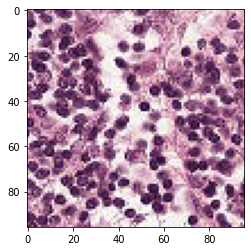

Example of image patch with cancer
{'TIFFTAG_DATETIME': '2018:11:15 17:21:31', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}


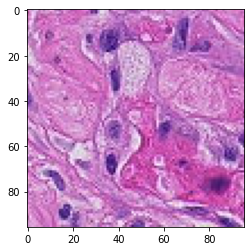

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  string
dtypes: object(1), string(1)
memory usage: 3.4+ MB


In [5]:
from skimage import io
import matplotlib.pyplot as plt


def showTifFile(filedir):
 
    dataset = gdal.Open(filedir)

    band1 = dataset.GetRasterBand(1) # Red channel
    band2 = dataset.GetRasterBand(2) # Green channel
    band3 = dataset.GetRasterBand(3) # Blue channel

    
    b1 = band1.ReadAsArray()
    b2 = band2.ReadAsArray()
    b3 = band3.ReadAsArray()
    print(dataset.GetMetadata())

    
    dataset = gdal.Open(filedir)
    img = np.dstack((b1, b2, b3))
    f = plt.figure()
    plt.imshow(img)
    plt.show()
   

print("Example of image patch without cancer")
showTifFile(os.path.join('/content/train', trainLabelsDFmodified.id[4]   ))
print("Example of image patch with cancer")
showTifFile(os.path.join('/content/train', trainLabelsDFmodified.id[1] ))


trainLabelsDFmodified['label'] = trainLabelsDFmodified['label'].astype('string') # convering object data type to string
trainLabelsDFmodified.info()


{'TIFFTAG_DATETIME': '2018:11:15 17:21:22', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
{'TIFFTAG_DATETIME': '2018:11:15 17:20:32', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
{'TIFFTAG_DATETIME': '2018:11:15 17:20:34', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
{'TIFFTAG_DATETIME': '2018:11:15 17:21:17', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
{'TIFFTAG_DATETIME': '2018:11:15 17:21:21', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
{'TIFFTAG_DATETIME': '2018:11:15 17:21:22', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
{'TIFFTAG_DATETIME': '2018:11:15 17:21:23', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [96, 96, 3]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}


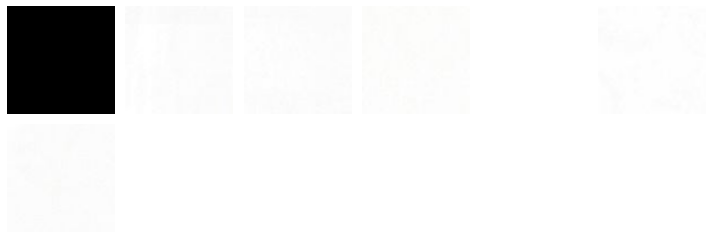

Unusable data sample
Deleting image  9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif
Deleting image  9071b424ec2e84deeb59b54d2450a6d0172cf701.tif
Deleting image  f6f1d771d14f7129a6c3ac2c220d90992c30c10b.tif
Deleting image  5f30d325d895d873d3e72a82ffc0101c45cba4a8.tif
Deleting image  54df3640d17119486e5c5f98019d2a92736feabc.tif
Deleting image  5a268c0241b8510465cb002c4452d63fec71028a.tif
Deleting image  c448cd6574108cf14514ad5bc27c0b2c97fc1a83.tif


In [6]:
#ustable pics

unusable = ['9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif', '9071b424ec2e84deeb59b54d2450a6d0172cf701.tif',
            'f6f1d771d14f7129a6c3ac2c220d90992c30c10b.tif', '5f30d325d895d873d3e72a82ffc0101c45cba4a8.tif',
            '54df3640d17119486e5c5f98019d2a92736feabc.tif', '5a268c0241b8510465cb002c4452d63fec71028a.tif',
            'c448cd6574108cf14514ad5bc27c0b2c97fc1a83.tif']

plt.figure(figsize=(10,10))
i = 0
for n in unusable:
    dataset = gdal.Open(TRAIN_DIR + n)

    band1 = dataset.GetRasterBand(1) # Red channel
    band2 = dataset.GetRasterBand(2) # Green channel
    band3 = dataset.GetRasterBand(3) # Blue channel

    
    b1 = band1.ReadAsArray()
    b2 = band2.ReadAsArray()
    b3 = band3.ReadAsArray()
    print(dataset.GetMetadata())

    
    img = np.dstack((b1, b2, b3))

    plt.subplot(6,6,i+1)
    plt.imshow(img) 
    plt.axis('off')
    i = i+1
    plt.tight_layout()
plt.show()

### Remove unusable
print("Unusable data sample")
for n in unusable:
    UnusableIdx = trainLabelsDFmodified[trainLabelsDFmodified['id'] == n].index
    trainLabelsDFmodified.drop(UnusableIdx, inplace=True)
    print ('Deleting image ', n)

## Data Genearators and building the model

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
os.environ["CUDA_VISIBLE_DEVICES"] = "0"         # Set for GPU use
device_name = tf.test.gpu_device_name()
print(device_name)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

SEED           = 1337
SPLIT_SIZE     = 0.2
BATCH_SIZE     = 32
IMAGE_SIZE     = (96,96)

datagen = ImageDataGenerator(rescale=1./255., validation_split=SPLIT_SIZE)

train_gen = datagen.flow_from_dataframe(
    dataframe  = trainLabelsDFmodified,
    directory  = TRAIN_DIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'training',
    batch_size = BATCH_SIZE,
    seed       = SEED,
    shuffle    = True,
    class_mode = 'binary',
    target_size = IMAGE_SIZE)

valid_gen = datagen.flow_from_dataframe(
    dataframe  = trainLabelsDFmodified,
    directory  = TRAIN_DIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'validation',
    batch_size = BATCH_SIZE,
    seed       = SEED,
    shuffle    = True,
    class_mode = 'binary',
    target_size = IMAGE_SIZE)



/device:GPU:0
Found 176015 validated image filenames belonging to 2 classes.
Found 44003 validated image filenames belonging to 2 classes.


## Step three:
## Model architecture
Multiple neural network models primarily consisting of primairly CNN models are used to fit the train data and evaluate their results. These models differ consists of varying number of CNN layers and different activation functions.
Model c1 uses three CNN layers and sigmoid activation function for the final dense activation layer, model c2 uses four CNN layers and sigmoid activation function for the final dense activation layer whereas, model c3 uses four CNN layers and softmax activation function for the final dense activation layer. All models use Adam optimizer with learning rate being 0.0001. 

In [11]:
# Variables
# Model Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

kernel_size     = (3,3)
pool_size       = (2,2)
input_shape     = (96,96,3)

first_filters   = 32
second_filters  = 64
third_filters   = 128
fouth_filters   = 256

dropout_conv = 0.3
dropout_dense = 0.3

train_steps = np.ceil(len(train_gen) / BATCH_SIZE)
val_steps = np.ceil(len(valid_gen) / BATCH_SIZE)

print('Steps:')
print('Train: %d | Validation: %d ' %(train_steps, val_steps))




optimizer       = Adam(learning_rate=0.0001)                 # SGD(lr=0.001, momentum=0.9), Adam, RMSprop
loss            = 'binary_crossentropy'                      # 'categorical_crossentropy', 'binary_crossentropy'
metric          = 'accuracy'
activation      = 'sigmoid'                                  # 'sigmoid'; 'softmax'
epochs          = 10
val_split       = 0.2

Steps:
Train: 172 | Validation: 43 


In [9]:
def model_custom(input_shape, activation):
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = activation))
    
    return model   

In [12]:
model_c1 = model_custom(input_shape, activation)
model_c1.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])



model_c1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [13]:
import time
s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
h1 = model_c1.fit(x                = train_gen,
                  steps_per_epoch  = train_steps,
                  validation_data  = valid_gen,
                  validation_steps = val_steps,
                  epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-s))

Epoch 1/10
172/172 [==============================] - 36s 110ms/step - loss: 0.6342 - accuracy: 0.6334 - auc: 0.6820 - val_loss: 0.5641 - val_accuracy: 0.7435 - val_auc: 0.8307
Epoch 2/10
172/172 [==============================] - 17s 99ms/step - loss: 0.5083 - accuracy: 0.7600 - auc: 0.8217 - val_loss: 0.5132 - val_accuracy: 0.7594 - val_auc: 0.8307
Epoch 3/10
172/172 [==============================] - 17s 97ms/step - loss: 0.4803 - accuracy: 0.7869 - auc: 0.8415 - val_loss: 0.4733 - val_accuracy: 0.7972 - val_auc: 0.8518
Epoch 4/10
172/172 [==============================] - 17s 101ms/step - loss: 0.4912 - accuracy: 0.7760 - auc: 0.8345 - val_loss: 0.5596 - val_accuracy: 0.7376 - val_auc: 0.8508
Epoch 5/10
172/172 [==============================] - 17s 97ms/step - loss: 0.4850 - accuracy: 0.7758 - auc: 0.8392 - val_loss: 0.4541 - val_accuracy: 0.8016 - val_auc: 0.8626
Epoch 6/10
172/172 [==============================] - 16s 92ms/step - loss: 0.4681 - accuracy: 0.7840 - auc: 0.8501 - 

In [14]:
def model_custom2(input_shape, activation):
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = activation))
    
    return model   

In [20]:
model_c2 = model_custom2(input_shape, activation)
model_c2.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])



model_c1.summary()

import time
s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
h2 = model_c2.fit(x                = train_gen,
                  steps_per_epoch  = train_steps,
                  validation_data  = valid_gen,
                  validation_steps = val_steps,
                  epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-s))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [15]:
model_c3 = model_custom2(input_shape, 'softmax')
model_c3.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])



model_c3.summary()

import time
s = time.time()
# with tf.device('/CPU:0'):              # Running on CPU
h3 = model_c3.fit(x                = train_gen,
                  steps_per_epoch  = train_steps,
                  validation_data  = valid_gen,
                  validation_steps = val_steps,
                  epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-s))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

In [17]:
#####################  Plot Loss Curves  #####################

def Plot_Train(hlist, start=1):

    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
  
    epoch_range = range(start, len(history['loss']) +1)
    s           = slice(start-1, None)
    n           = int(len(history.keys()) / 2)
    
    plt.figure(figsize=[14,4])
    for i in range(n):
        k = list(history.keys())[i]
        plt.subplot(1, n, i+1)
        plt.plot(epoch_range, history[k][s], label='Training')
        plt.plot(epoch_range, history['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

Results of CNN model with three CNN layers and final activation layer is sigmoid


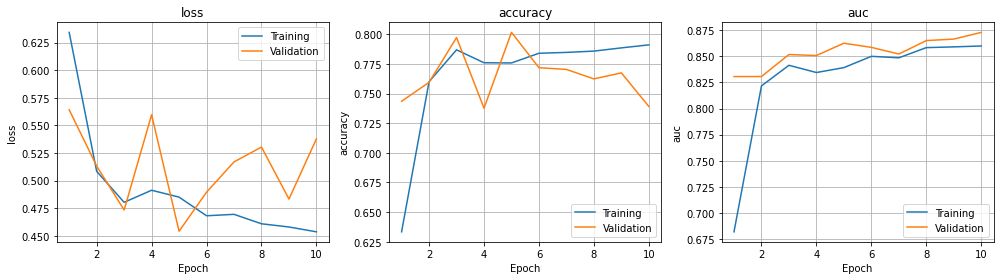

In [22]:
print("Results of CNN model with three CNN layers and final activation layer is sigmoid")
Plot_Train([h1])

Results of CNN model with four CNN layers and final activation layer is softmax


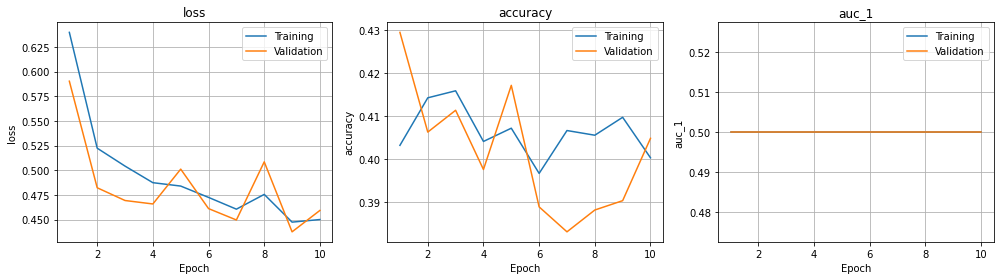

In [19]:
print("Results of CNN model with four CNN layers and final activation layer is softmax")
Plot_Train([h3])

Results of CNN model with four CNN layers and final activation layer is sigmoid


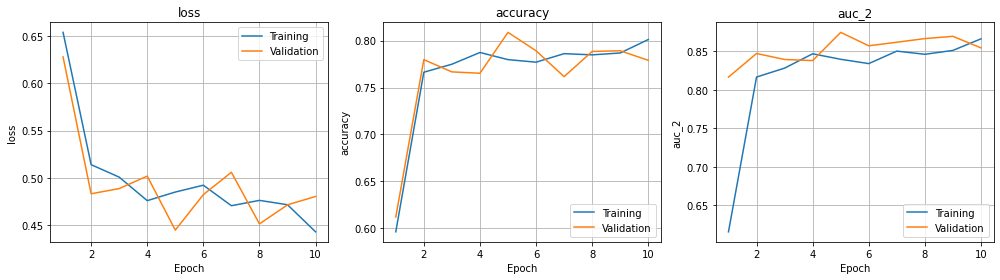

In [21]:
print("Results of CNN model with four CNN layers and final activation layer is sigmoid")
Plot_Train([h2])

##Step 4:
## Results and analysis
Hyperparamter tuning is done on learning rate with adam optimizer and with the number of neuronns in the final activation layer. After Hyperparameter tuning, 288 units for the final activation layer and 0.0001 for the learning rate was deemed to be ideal for the bets validation accuracy score (0.81).

In [32]:
!pip install -q -U keras-tuner
import keras_tuner as kt


def model_builder(hp):

  model = Sequential()
  model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
  model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
  model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = pool_size)) 
  model.add(Dropout(dropout_conv))
  
  model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
  model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
  model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
  model.add(MaxPooling2D(pool_size = pool_size))
  model.add(Dropout(dropout_conv))
  
  model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
  model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
  model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
  
  model.add(Dropout(dropout_conv))

  model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
  model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
  model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
  model.add(MaxPooling2D(pool_size = pool_size))
  model.add(Dropout(dropout_conv))
  
  model.add(Flatten())
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='sigmoid'))

  model.add(Dropout(dropout_dense))
  model.add(Dense(1, activation = activation))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=[metric, tf.keras.metrics.AUC()])

  return model

  


  

In [43]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name='kt')
  
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [44]:
tuner.search(     x                = train_gen,
                  steps_per_epoch  = train_steps,
                  validation_data  = valid_gen,
                  validation_steps = val_steps,
                  epochs           = epochs)

Trial 30 Complete [00h 01m 51s]
val_accuracy: 0.614098846912384

Best val_accuracy So Far: 0.8059592843055725
Total elapsed time: 00h 22m 49s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [48]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the final densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")
print("Best val_accuracy So Far: 0.81")


The hyperparameter search is complete. The optimal number of units in the final densely-connected
layer is 288 and the optimal learning rate for the optimizer
is 0.0001.

Best val_accuracy So Far: 0.81


## Predicting the Model on Test data

In [53]:
def getFinalModel(input_shape, activation):
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(fouth_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Flatten())
    model.add(Dense(288, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = activation))
    
    return model  


finalModel = getFinalModel(input_shape, 'sigmoid')
optimizer       = Adam(learning_rate=0.0001) 
finalModel.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

finalModel = tuner.get_best_models()[0]


In [55]:
finalModel = tuner.get_best_models()[0]

In [56]:
test_df = pd.read_csv('../content/' + 'sample_submission.csv')
test_df['filename'] = test_df.id + '.tif'

print('Test Images:', len(os.listdir(TEST_DIR)))

datagen_test = ImageDataGenerator(rescale=1./255.)

test_gen = datagen_test.flow_from_dataframe(
    dataframe  = test_df,
    directory  = TEST_DIR,
    color_mode = 'rgb',
    x_col      = 'filename',
    batch_size = 32,
    seed       = SEED,
    shuffle    = False,
    class_mode = None,
    target_size = IMAGE_SIZE)

test_steps = np.ceil(len(test_gen) / BATCH_SIZE)
test_images_path = len(os.listdir(TEST_DIR))

print('Test Images in path:', test_images_path)
print('Test Dataframe Size:', len(test_df))
print('Steps: ', test_steps)



Test Images: 57458
Found 57458 validated image filenames.
Test Images in path: 57458
Test Dataframe Size: 57458
Steps:  57.0


In [57]:
predictions = finalModel.predict(
    test_gen,
#    steps=test_steps,
    verbose=1)
submission = pd.read_csv('../content/' + 'sample_submission.csv', index_col='id')
submission.label = predictions
submission.to_csv('./submission.csv')

1796/1796 [==============================] - 40s 22ms/step


## Step 5
## Conclusion and results
This notebook involved training a binary image classification neural network with the help of Keras Deep learning framework. CNN architecture was chosen as the data was in image form to tackle the enormous dimensions of image data. Various neural networks with different number of convolution layers and different final activation layers were implemented to explore the effect of these parameters on validation score. Finally, 288 units for the final activation layer and a learning rate value of 0.0001 with Adam optimizer was chosen. Furthermore, test data was predicted with this data to obtain the sbmission csv which  was submitted to Kaggle to get the score for the test data.